In [37]:
import os

import numpy as np
import pandas as pd

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib
from joblib import Parallel, delayed

import cv2
import matplotlib.pyplot as plt

In [14]:
path_train_glioma = os.path.join("agyikepek_4_osztaly", "Training", "glioma")
path_train_meningioma = os.path.join("agyikepek_4_osztaly", "Training", "meningioma")
path_train_notumor = os.path.join("agyikepek_4_osztaly", "Training", "notumor")
path_train_pituitary = os.path.join("agyikepek_4_osztaly", "Training", "pituitary")

path_test_glioma = os.path.join("agyikepek_4_osztaly", "Testing", "glioma")
path_test_meningioma = os.path.join("agyikepek_4_osztaly", "Testing", "meningioma")
path_test_notumor = os.path.join("agyikepek_4_osztaly", "Testing", "notumor")
path_test_pituitary = os.path.join("agyikepek_4_osztaly", "Testing", "pituitary")

In [15]:
def save_images(PATH, type) -> pd.DataFrame:

    df = pd.DataFrame(columns=["img", "type"])

    for file in os.listdir(PATH):
        img = cv2.imread(os.path.join(PATH, file))      

        temp_df = pd.DataFrame({"img": [img], "type": [type]})
        
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

In [16]:
train_glioma_df = save_images(path_train_glioma, "glioma")
train_meningioma_df = save_images(path_train_meningioma, "meningioma")
train_notumor_df = save_images(path_train_notumor, "notumor")
train_pituitary_df = save_images(path_train_pituitary, "pituitary")

test_glioma_df = save_images(path_test_glioma, "glioma")
test_meningioma_df = save_images(path_test_meningioma, "meningioma")
test_notumor_df = save_images(path_test_notumor, "notumor")
test_pituitary_df = save_images(path_test_pituitary, "pituitary")

In [17]:
train_df = pd.concat([train_glioma_df, train_meningioma_df, train_notumor_df, train_pituitary_df], axis=0)

In [18]:
print("Train categories and counts: ")
train_df["type"].value_counts()

Train categories and counts: 


type
notumor       1595
pituitary     1344
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [19]:
test_df = pd.concat([test_glioma_df, test_meningioma_df, test_notumor_df, test_pituitary_df], axis=0)

In [20]:
print("Test categories and counts: ")
test_df["type"].value_counts()

Test categories and counts: 


type
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64

In [21]:
def apply_thresholding(img: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    A bemeneti képből készít három küszöbértékkel rendelkező képet.

    Bemenet:
    - img (numpy.ndarray): A kép, amire a küszöbértékelést alkalmazzuk.

    Kimenet:
    - tuple[np.ndarray, np.ndarray, np.ndarray]: A három küszöbértékkel rendelkező kép tuple formájában.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th1 = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    th3 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    return th1, th2, th3

In [ ]:
IMAGE_SIZE = (128, 128)  # Resize to speed up HOG extraction
PCA_COMPONENTS = 100  # Number of PCA components to keep
N_JOBS = -1  # Use all available CPU cores

In [ ]:
# 1. Apply thresholding, resize images, and group the data
def prepare_thresholded_data(dataframes, labels):
    images = []
    y = []
    for df, label in zip(dataframes, labels):
        print(label)
        for img in df["img"]:
            th1, _, _ = apply_thresholding(img)  # Using global thresholding (th1)
            img_resized = cv2.resize(th1, IMAGE_SIZE)  # Resize to 128x128
            images.append(img_resized)
            y.append(label)
    return images, y

train_dataframes = [train_glioma_df, train_meningioma_df, train_notumor_df, train_pituitary_df]
train_labels = ["glioma", "meningioma", "notumor", "pituitary"]
X_train_images, y_train = prepare_thresholded_data(train_dataframes, train_labels)


glioma
meningioma
notumor
pituitary


In [ ]:
# 2. Parallelized HOG Feature Extraction
def compute_hog(img):
    features, _ = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

X_train = Parallel(n_jobs=N_JOBS)(delayed(compute_hog)(img) for img in X_train_images)

# Convert to NumPy array
X_train = np.array(X_train) #2m40s

In [ ]:
# 3. Apply PCA for Dimensionality Reduction
pca = PCA(n_components=PCA_COMPONENTS)
X_train_pca = pca.fit_transform(X_train)

In [26]:
# 4. Prepare test data
test_dataframes = [test_glioma_df, test_meningioma_df, test_notumor_df, test_pituitary_df]
test_labels = ["glioma", "meningioma", "notumor", "pituitary"]
X_test_images, y_test = prepare_thresholded_data(test_dataframes, test_labels)
X_test = Parallel(n_jobs=N_JOBS)(delayed(compute_hog)(img) for img in X_test_images)
X_test = np.array(X_test)
X_test_pca = pca.transform(X_test)

glioma
meningioma
notumor
pituitary


In [ ]:
# 5. Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_jobs=N_JOBS)
model.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [28]:
# 6. Save the trained model
joblib.dump(model, "brain_tumor_classifier.pkl")
joblib.dump(pca, "pca_transformer.pkl")

['pca_transformer.pkl']

In [ ]:
# 7. Predict and Evaluate
y_pred = model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      glioma       0.82      0.82      0.82       300
  meningioma       0.82      0.82      0.82       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.96      0.92      0.94       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



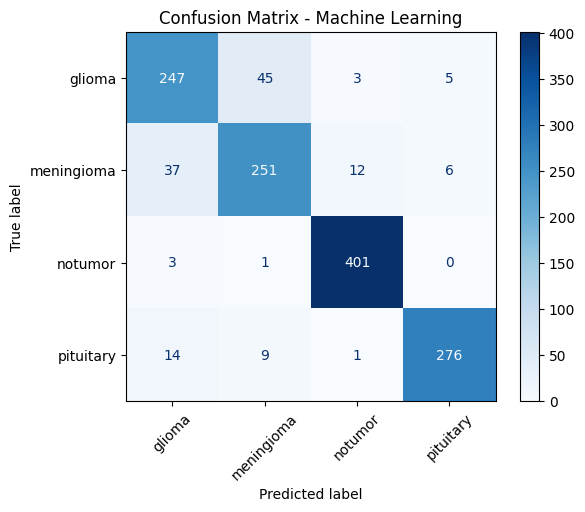

In [42]:
cm = confusion_matrix(y_test, y_pred, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Machine Learning')
plt.show()